In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
params = (("period", 200),
    ("devfactor", 1),
    ("size", 1),
    ("debug", False)
    )

In [3]:
class TestStrategy(bt.Strategy):
    params = (
        ("period", 500),
        ("devfactor", 2),
        ("size", 0.5),
        ("debug", False)
        )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt, txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        self.boll = bt.indicators.BollingerBands(period=self.p.period, devfactor=self.p.devfactor)

        

    def next(self):
        # Simply log the closing price of the series from the reference
        #print(dir(self.datas))
        
        orders = self.broker.get_orders_open()
        if orders:
            for order in orders:
                self.broker.cancel(order)
 
        if not self.position:
 
            if self.data.close > self.boll.lines.top:
                
                self.sell(exectype=bt.Order.Stop, price=self.dataclose[0], size=self.p.size)
                #self.sell(exectype=bt.Order.Stop, price=self.boll.lines.top[0], size=self.p.size)

            if self.data.close < self.boll.lines.bot:
                self.buy(exectype=bt.Order.Stop, price=self.dataclose[0], size=self.p.size)
                #self.buy(exectype=bt.Order.Stop, price=self.boll.lines.bot[0], size=self.p.size)

 
 
        else:
 
            if self.position.size > 0:
                if self.data.close > self.boll.lines.top:
                    self.sell(exectype=bt.Order.Stop, price=self.dataclose[0], size=self.p.size)
            else:
                if self.data.close < self.boll.lines.bot:
                    self.buy(exectype=bt.Order.Stop, price=self.dataclose[0], size=self.p.size)
                    #self.buy(exectype=bt.Order.Stop, price=self.boll.lines.bot[0], size=self.p.size)
 
        #self.log('Close, %.2f' % self.dataclose[0])
        
        if self.p.debug:
            print('---------------------------- NEXT ----------------------------------')
            print("1: Data Name:                            {}".format(data._name))
            print("2: Bar Num:                              {}".format(len(data)))
            print("3: Current date:                         {}".format(data.datetime.datetime()))
            print('4: Open:                                 {}'.format(data.open[0]))
            print('5: High:                                 {}'.format(data.high[0]))
            print('6: Low:                                  {}'.format(data.low[0]))
            print('7: Close:                                {}'.format(data.close[0]))
            print('8: Volume:                               {}'.format(data.volume[0]))
            print('9: Position Size:                       {}'.format(self.position.size))
            print('--------------------------------------------------------------------')
 
    def notify_trade(self,trade):
        if trade.isclosed:
            dt = self.data.datetime.date()
 
            print('---------------------------- TRADE ---------------------------------')
            print("1: Data Name:                            {}".format(trade.data._name))
            print("2: Bar Num:                              {}".format(len(trade.data)))
            print("3: Current date:                         {}".format(dt))
            print('4: Status:                               Trade Complete')
            print('5: Ref:                                  {}'.format(trade.ref))
            print('6: PnL:                                  {}'.format(round(trade.pnl,2)))
            print('--------------------------------------------------------------------')
        
        

In [7]:
class MyCSVData(bt.feeds.GenericCSVData):
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d %H:%M:%S'),
        ('tmformat', '%H:%M:%S'),

        ('datetime', 0),
        ('time', -1),
        ('open', 7),
        ('high', 3),
        ('low', 6),
        ('close', 1),
        ('volume', 10),
        ('openinterest', 2),
    )      
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    datapath = 'FXBTUSD-1m-data.csv'
    
    # Create a Data Feed
    data = MyCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2020, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2020, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    cerebro.addsizer(bt.sizers.FixedReverser, stake=10)
    # Set our desired cash start
    
    cerebro.addanalyzer(bt.analyzers.PyFolio)
    
    cerebro.broker.setcash(8000.0)
    cerebro.broker.setcommission(commission=2, margin=2000.0, mult=1.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    results = cerebro.run()
    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 8000.00
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              830
3: Current date:                         2020-01-01
4: Status:                               Trade Complete
5: Ref:                                  13
6: PnL:                                  41.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              1354
3: Current date:                         2020-01-01
4: Status:                               Trade Complete
5: Ref:                                  14
6: PnL:                                  32.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:   

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              13652
3: Current date:                         2020-01-10
4: Status:                               Trade Complete
5: Ref:                                  32
6: PnL:                                  32.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              14885
3: Current date:                         2020-01-11
4: Status:                               Trade Complete
5: Ref:                                  33
6: PnL:                                  -100.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBT

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              28091
3: Current date:                         2020-01-20
4: Status:                               Trade Complete
5: Ref:                                  51
6: PnL:                                  86.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              28691
3: Current date:                         2020-01-20
4: Status:                               Trade Complete
5: Ref:                                  52
6: PnL:                                  22.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUS

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              40888
3: Current date:                         2020-01-29
4: Status:                               Trade Complete
5: Ref:                                  70
6: PnL:                                  -108.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              41420
3: Current date:                         2020-01-29
4: Status:                               Trade Complete
5: Ref:                                  71
6: PnL:                                  75.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTU

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              53182
3: Current date:                         2020-02-06
4: Status:                               Trade Complete
5: Ref:                                  92
6: PnL:                                  13.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              53293
3: Current date:                         2020-02-07
4: Status:                               Trade Complete
5: Ref:                                  93
6: PnL:                                  44.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUS

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              69118
3: Current date:                         2020-02-17
4: Status:                               Trade Complete
5: Ref:                                  112
6: PnL:                                  -2.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              69680
3: Current date:                         2020-02-18
4: Status:                               Trade Complete
5: Ref:                                  113
6: PnL:                                  42.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBT

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              79919
3: Current date:                         2020-02-25
4: Status:                               Trade Complete
5: Ref:                                  132
6: PnL:                                  -19.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              80064
3: Current date:                         2020-02-25
4: Status:                               Trade Complete
5: Ref:                                  133
6: PnL:                                  66.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBT

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              95238
3: Current date:                         2020-03-07
4: Status:                               Trade Complete
5: Ref:                                  152
6: PnL:                                  34.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              95693
3: Current date:                         2020-03-07
4: Status:                               Trade Complete
5: Ref:                                  153
6: PnL:                                  38.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXB

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              109319
3: Current date:                         2020-03-16
4: Status:                               Trade Complete
5: Ref:                                  171
6: PnL:                                  205.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              109503
3: Current date:                         2020-03-17
4: Status:                               Trade Complete
5: Ref:                                  172
6: PnL:                                  151.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            F

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              119841
3: Current date:                         2020-03-24
4: Status:                               Trade Complete
5: Ref:                                  190
6: PnL:                                  -120.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              120013
3: Current date:                         2020-03-24
4: Status:                               Trade Complete
5: Ref:                                  191
6: PnL:                                  257.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              135537
3: Current date:                         2020-04-04
4: Status:                               Trade Complete
5: Ref:                                  210
6: PnL:                                  57.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              135835
3: Current date:                         2020-04-04
4: Status:                               Trade Complete
5: Ref:                                  211
6: PnL:                                  39.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaX

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              149282
3: Current date:                         2020-04-13
4: Status:                               Trade Complete
5: Ref:                                  229
6: PnL:                                  69.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              150330
3: Current date:                         2020-04-14
4: Status:                               Trade Complete
5: Ref:                                  230
6: PnL:                                  68.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaX

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              164138
3: Current date:                         2020-04-23
4: Status:                               Trade Complete
5: Ref:                                  248
6: PnL:                                  -184.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              164621
3: Current date:                         2020-04-24
4: Status:                               Trade Complete
5: Ref:                                  249
6: PnL:                                  34.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            F

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              175543
3: Current date:                         2020-05-01
4: Status:                               Trade Complete
5: Ref:                                  267
6: PnL:                                  180.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              176139
3: Current date:                         2020-05-02
4: Status:                               Trade Complete
5: Ref:                                  268
6: PnL:                                  164.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            F

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              190304
3: Current date:                         2020-05-12
4: Status:                               Trade Complete
5: Ref:                                  286
6: PnL:                                  115.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              190877
3: Current date:                         2020-05-12
4: Status:                               Trade Complete
5: Ref:                                  287
6: PnL:                                  45.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            F

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              207206
3: Current date:                         2020-05-23
4: Status:                               Trade Complete
5: Ref:                                  306
6: PnL:                                  343.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              208073
3: Current date:                         2020-05-24
4: Status:                               Trade Complete
5: Ref:                                  307
6: PnL:                                  176.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              225010
3: Current date:                         2020-06-05
4: Status:                               Trade Complete
5: Ref:                                  326
6: PnL:                                  -30.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              226633
3: Current date:                         2020-06-06
4: Status:                               Trade Complete
5: Ref:                                  327
6: PnL:                                  -73.75
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              242391
3: Current date:                         2020-06-17
4: Status:                               Trade Complete
5: Ref:                                  345
6: PnL:                                  28.0
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              242788
3: Current date:                         2020-06-17
4: Status:                               Trade Complete
5: Ref:                                  346
6: PnL:                                  24.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXB

---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              261138
3: Current date:                         2020-06-30
4: Status:                               Trade Complete
5: Ref:                                  364
6: PnL:                                  6.5
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXBTUSD-1m-data
2: Bar Num:                              261561
3: Current date:                         2020-06-30
4: Status:                               Trade Complete
5: Ref:                                  365
6: PnL:                                  29.25
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            FaXB

<IPython.core.display.Javascript object>


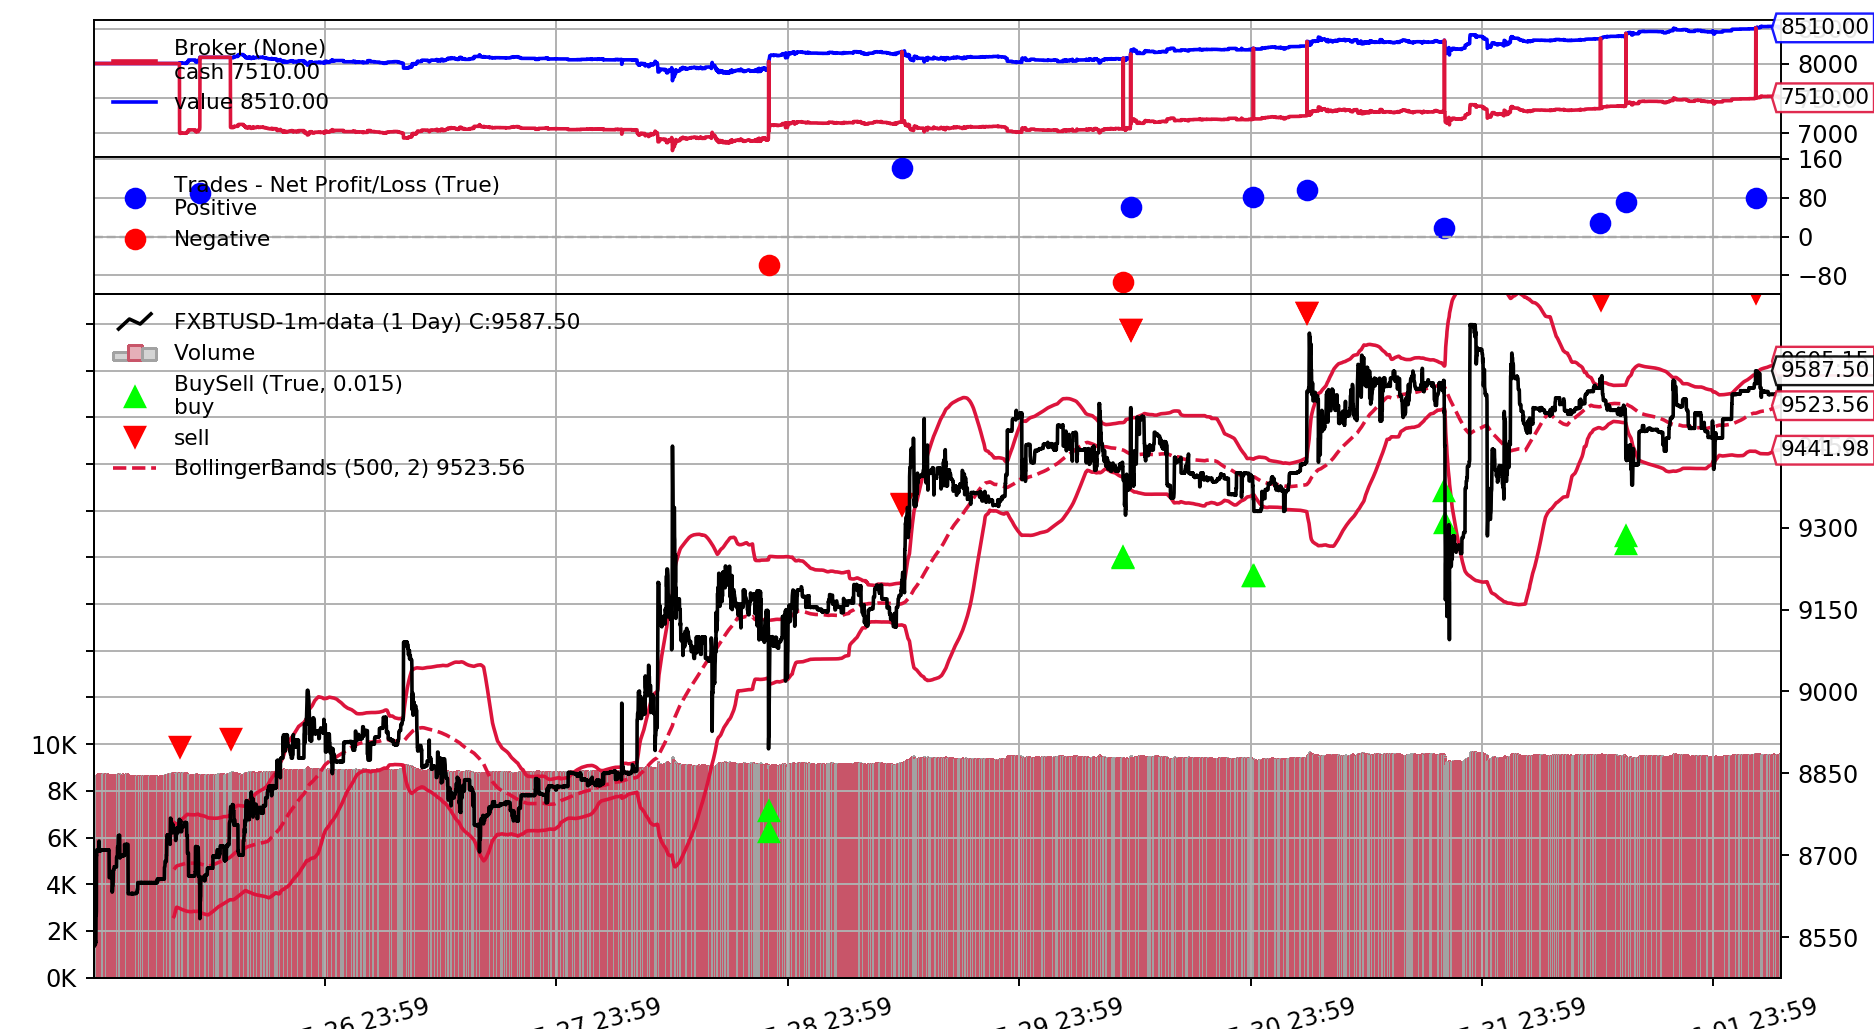

[[<Figure size 432x288 with 4 Axes>]]

In [5]:
%matplotlib notebook
cerebro.plot()

Entire data start date: 2020-01-01
Entire data end date: 2020-07-01


Backtest Months: 8


Performance statistics,Backtest
annual_return,1.32
annual_volatility,0.25
sharpe_ratio,3.47
calmar_ratio,26.47
stability_of_timeseries,0.97
max_drawdown,-0.05
omega_ratio,1.89
sortino_ratio,6.47
skew,0.68
kurtosis,2.37


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,4.99,2020-03-28,2020-04-02,2020-04-15,13
1,4.90,2020-03-07,2020-03-09,2020-03-13,5
2,4.58,2020-01-01,2020-01-08,2020-01-20,14
3,4.10,2020-04-28,2020-04-30,2020-05-02,4
4,3.82,2020-05-03,2020-05-10,2020-05-18,11




[-0.028 -0.051]


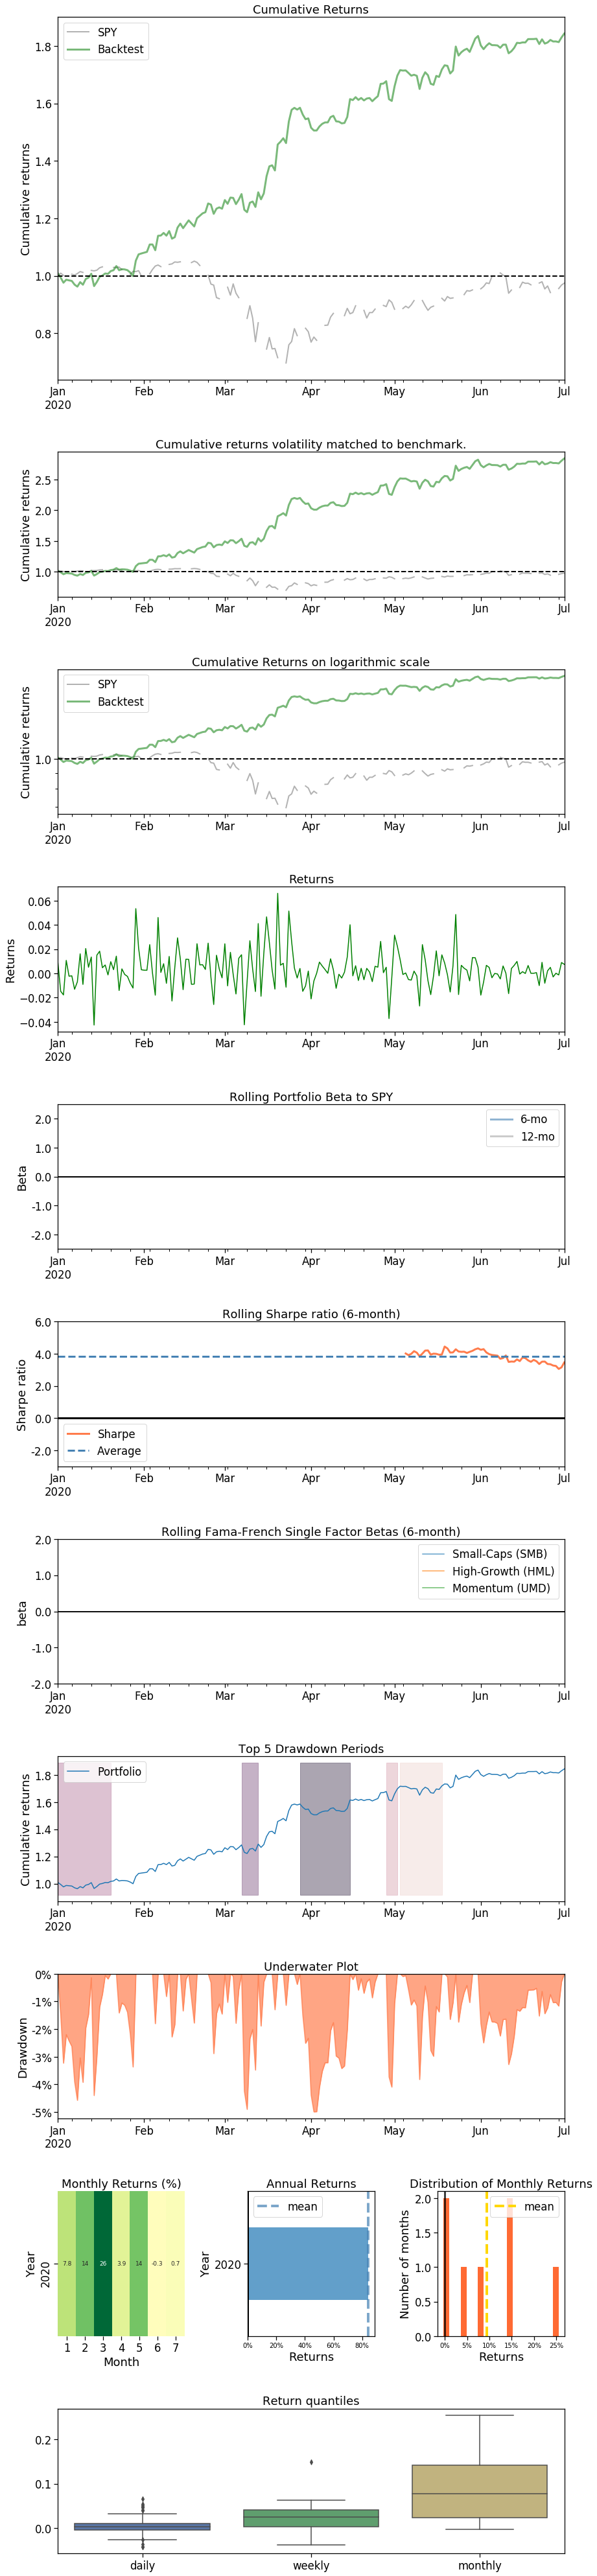

Stress Events,mean,min,max
New Normal,0.35%,-4.27%,6.60%


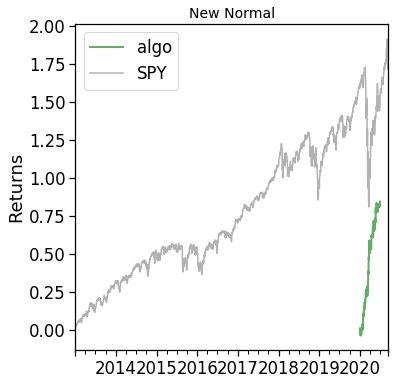

Top 10 long positions of all time,max
FaXBTUSD-1m-data,12.99%


Top 10 short positions of all time,max


Top 10 positions of all time,max
FaXBTUSD-1m-data,12.99%


All positions ever held,max
FaXBTUSD-1m-data,12.99%


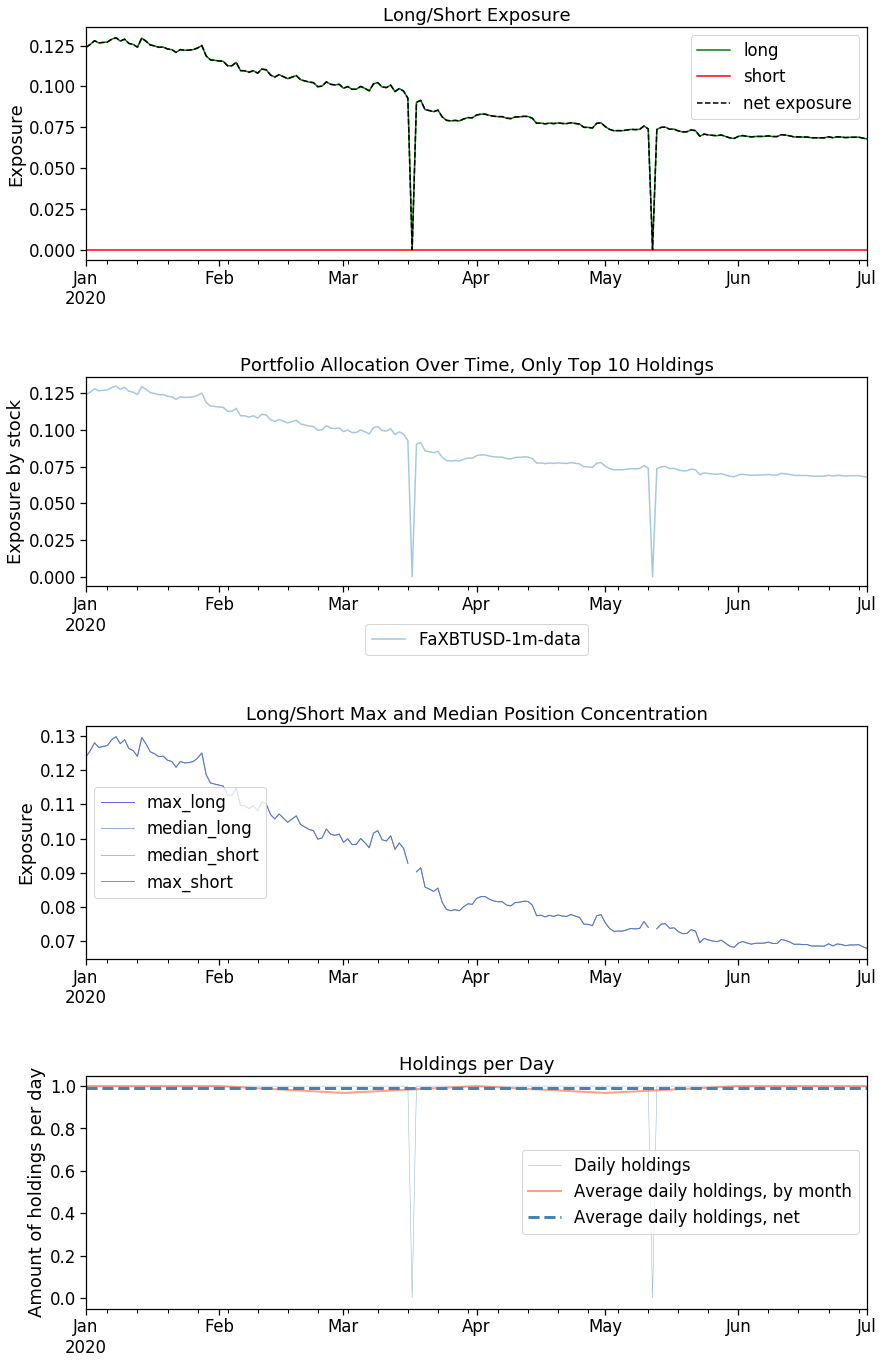

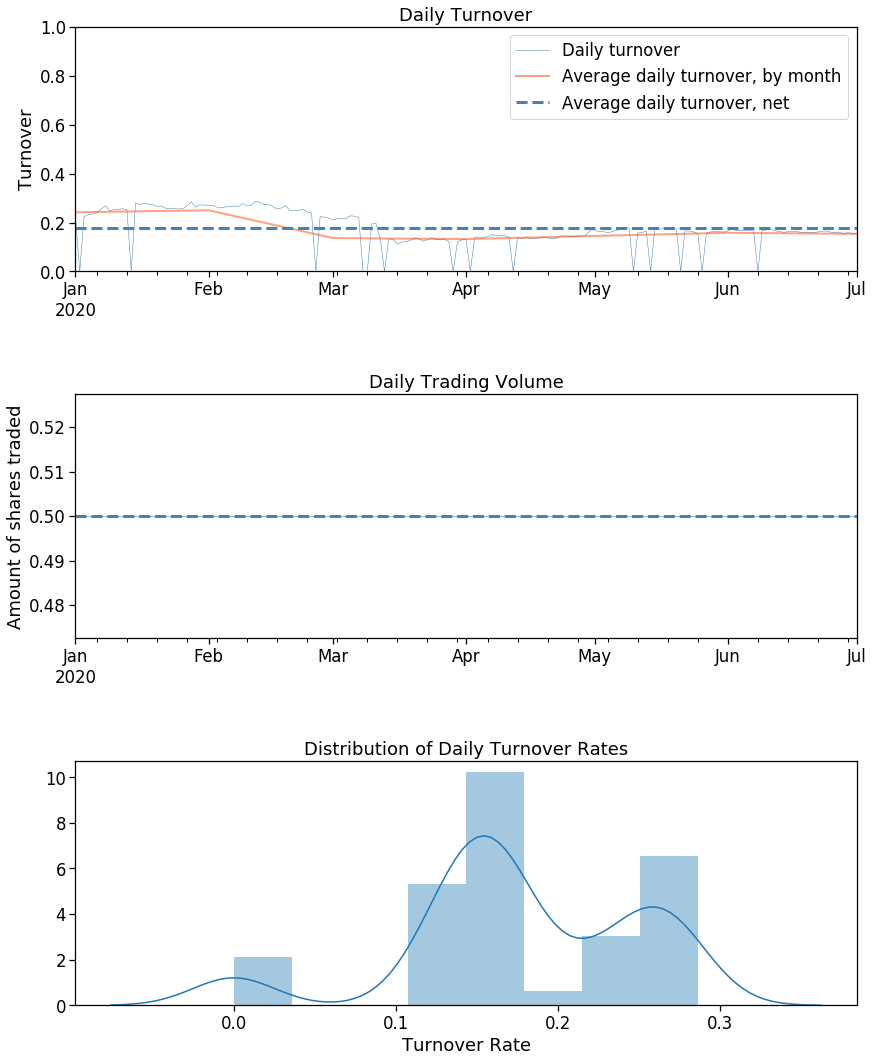

KeyError: 'close_dt'

In [8]:
import pyfolio as pf

%matplotlib inline
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,  # This date is sample specific
    #live_start_date='2020-03-01',
    round_trips=True)